In [41]:
import xarray as xr

In [42]:
# Specify budget terms
terms = {}
terms['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
                 'boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff',
                 'frazil_heat_tendency','internal_heat_heat_tendency']
terms['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
                 'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
terms['thickness'] = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
                      'boundary_forcing_h_tendency']
# Specify different diagnostic grids
grids = ['natv']
# Specify vertical index name in grid
vertind = {'native':'zl','z':'z_l','rho2':'rho2_l'}

In [43]:
# Load data on the native grid, z* grid and rho2 grids
# There are separate files for each grid,
# so loop through to load and place each dataset into a dictionary
# Within the loop, calculate the LHS and RHS for each tracer for each grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1mt/'
prefix = '19000101.ocean_'
ds = {}
lhs = {}
rhs = {}
for grid in grids:
    # Diagnostics were saved into different files
    suffixs = ['xtra','thck','heat','salt','surf']
    ds[grid] = xr.Dataset()
    for suffix in suffixs:
        filename = prefix+grid+'_'+suffix+'*.nc'
        dsnow = xr.open_mfdataset(rootdir+filename).isel(time=0)
        ds[grid] = xr.merge([ds[grid],dsnow])

## Balance of depth integrated fluxes and surface fluxes
### Heat
```hfds = boundary_forcing_heat_tendency + frazil_heat_tendency```

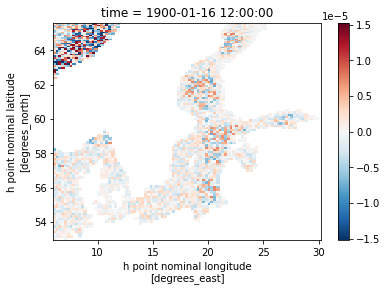

In [4]:
(ds['natv']['hfds']-ds['natv']['boundary_forcing_heat_tendency'].sum('zl')-ds['natv']['frazil_heat_tendency'].sum('zl')).plot()

### Salt
```sfdsi = boundary_forcing_salt_tendency```  
Note that `sfdsi` includes basal ice salt flux and salt restoring

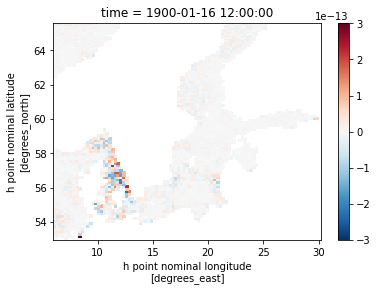

In [10]:
(ds['natv']['sfdsi']-ds['natv']['boundary_forcing_salt_tendency'].sum('zl')).plot()

### Mass
```wfo/1035 = boundary_forcing_h_tendency```  
Here, a conversion from thickness to mass (or vice versa) is required. The minimum error is achieved when the surface flux is divided by a reference density of 1035.

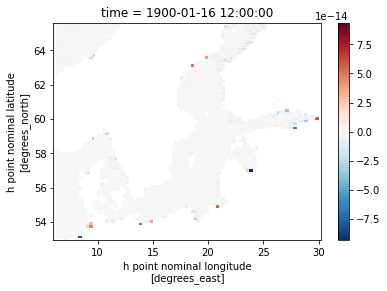

In [33]:
(ds['natv']['wfo']/1035.-ds['natv']['boundary_forcing_h_tendency'].sum('zl')).plot()

## Watermass transformation from 3D and 2D fluxes
Mass flux, salt flux, and heat flux all impact density.

In [102]:
def _calc_densitytendency(Qs,Qh,S,alpha,beta,Cp=4200):
    
    F = xr.Dataset()
    F['heat'] = (alpha/Cp)*Qh
    F['fw'] = -Qs*S*beta
    F['total'] = F['heat']+F['fw']
    
    return F

In [103]:
F = _calc_densitytendency(Qfw=ds['natv']['wfo'],
                          Qheat=ds['natv']['hfds'],
                          S=ds['natv']['sos'],
                          alpha=ds['natv']['drho_dT'].isel(zl=0),
                          beta=ds['natv']['drho_dS'].isel(zl=0))

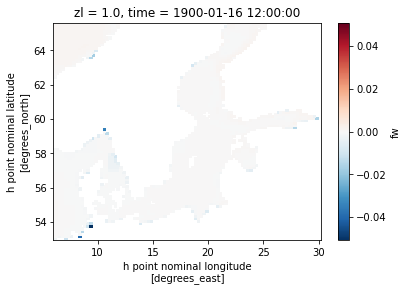

In [104]:
F['fw'].plot()

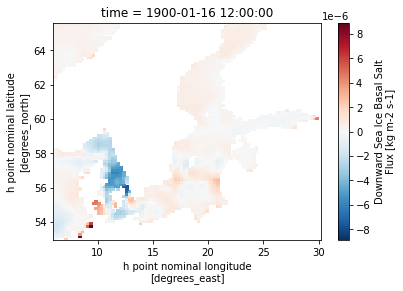

In [105]:
ds['natv']['sfdsi'].plot()

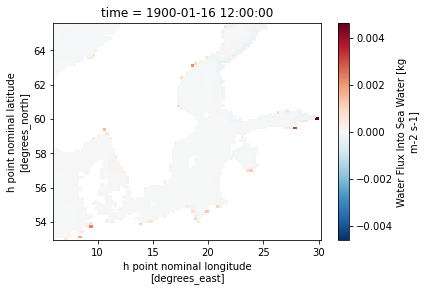

In [117]:
ds['natv']['wfo'].plot()

In [122]:
# Create a delta function
# coordinate of top level
k = ds['natv']['zl'].isel(zl=0)
# inverse thickness
# idz = 1/ds['natv']['thkcello']
idz = xr.ones_like(ds['natv']['thkcello'])
# Select only top level
idz=idz.where(array['zl']==k,0)

In [131]:
# Specify 3D arrays
# Use idz to convert 2D arrays to 3D
Qs=idz*ds['natv']['wfo']-idz*ds['natv']['sfdsi']
# Qs=idz*ds['natv']['wfo']-ds['natv']['boundary_forcing_salt_tendency']
Qh=ds['natv']['boundary_forcing_heat_tendency']
S=ds['natv']['salt']
alpha=ds['natv']['drho_dT']
beta=ds['natv']['drho_dS']

F = _calc_densitytendency(Qs,Qh,S,alpha,beta)

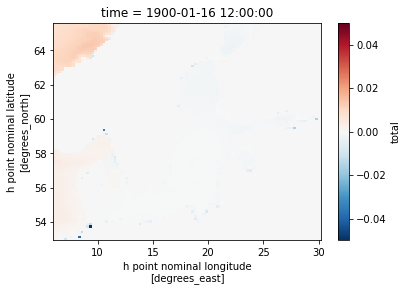

In [132]:
F['total'].sum('zl').plot()

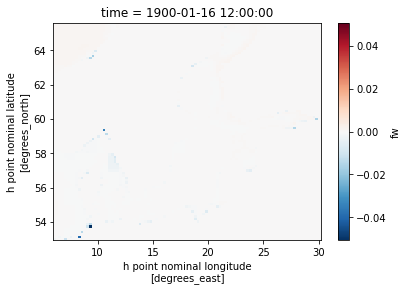

In [133]:
F['fw'].sum('zl').plot()

In [116]:
ds['natv']

<xarray.Dataset>
Dimensions:                         (nv: 2, xh: 97, xq: 97, yh: 105, yq: 105, zi: 76, zl: 75)
Coordinates:
  * xh                              (xh) float64 6.125 6.375 ... 29.88 30.12
  * yh                              (yh) float64 53.01 53.16 ... 65.48 65.56
  * zl                              (zl) float64 1.0 3.0 ... 3.591e+03 5.111e+03
    time                            object 1900-01-16 12:00:00
  * nv                              (nv) float64 1.0 2.0
  * xq                              (xq) float64 6.25 6.5 6.75 ... 30.0 30.25
  * yq                              (yq) float64 53.09 53.24 ... 65.52 65.6
  * zi                              (zi) float64 0.0 2.0 ... 3.722e+03 6.5e+03
Data variables:
    rhoinsitu                       (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    rhopot0                         (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    rhopot2                         (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    drho_dT                         (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    drho_dS                         (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    umo                             (zl, yh, xq) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    vmo                             (zl, yq, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    e                               (zi, yh, xh) float32 dask.array<chunksize=(76, 105, 97), meta=np.ndarray>
    average_T1                      datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    average_T2                      datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    average_DT                      timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_bnds                       (nv) timedelta64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    thkcello                        (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    dhdt                            (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    dynamics_h_tendency             (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    vert_remap_h_tendency           (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    boundary_forcing_h_tendency     (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    internal_heat_h_tendency        (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    temp                            (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    opottemptend                    (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    opottempdiff                    (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    opottemppmdiff                  (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    boundary_forcing_heat_tendency  (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    frazil_heat_tendency            (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    T_advection_xy                  (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    Th_tendency_vert_remap          (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    internal_heat_heat_tendency     (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    salt                            (zl, yh, xh) float32 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    osalttend                       (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    osaltdiff                       (zl, yh, xh) float64 dask.array<chunksize=(75, 105, 97), meta=np.ndarray>
    osaltpmdiff                